In [39]:
import pandas as pd
import numpy as np
import random
import string

In [69]:
with open('Data/wordle_words.txt') as f:
    lines = f.readlines()

def select_words(lis, l):
    #takes parameters l and lis, returns values of lis that only have a length=l.
    #accounts for the fact that our word list has \n after every word, and corrects this data error.
    new = np.array([])
    for word in lis:
        word = word[:-1]
        if len(word) == l:
            new = np.append(new, word)
    return new
    
word_array = select_words(lines, 5)

In [70]:
def replace_char(word, char, index):
    l_word = list(word)
    l_word[index] = char
    return "".join(l_word)


HALF_CORRECT = 1
FULL_CORRECT = 2
INCORRECT = 0

class Squabble:
    
    #creates a squabble game, parameters are self-evident.
    def __init__(self, solution, word_array, max_guesses=6):
        self.solution = str.lower(solution)
        self.word_array = word_array
        self.max_guesses = max_guesses
        self.guess_count = 0
        self.guesses = np.array([])
        self.solved = False

    """ 
    adds a guess to the list of guesses
    returns an array of numbers, each item in the array corresponds to a character, in order.
     NOTHING = not in word (Gray), 
     HALF_CORRECT = in word but wrong spot (Yellow), 
     FULL_CORRECT = in word and in correct place (Green)
    """
    def guess(self, guess):
        guess = str.lower(guess)
        self.guesses = np.append(self.guesses, guess)
        self.guess_count += 1

        #if our guess isnt a viable word, we return None
        #if not guess in word_array:
        #    return None

        #return list of FULL_CORRECT if we guessed the solution
        if guess == self.solution or self.guess_count >= self.max_guesses:
            self.solved = True
        #if we didnt get it correct, and we are out of guesses 

        guess_values = [INCORRECT for i in range(len(self.solution))]
        temp_solution = self.solution

        #sets our green letters == FULL_CORRECT
        #removes green letters from the solution so that we don't have errors
        for i in range(len(self.solution)):
            if temp_solution[i] == guess[i]:
                temp_solution = replace_char(temp_solution, ' ', i)
                guess_values[i] = FULL_CORRECT

        #sets our yellow letters == HALF_CORRECT
        #removes yellow letters from solution so that we dont have repeating yellows
        for i in range(len(guess)):
            if guess[i] in temp_solution and not guess_values[i] == FULL_CORRECT:
                guess_values[i] = HALF_CORRECT
                temp_solution = replace_char(temp_solution, ' ', temp_solution.find(guess[i]))
        return guess_values

In [71]:
game = Squabble(word_array[random.randint(0, len(word_array))], word_array)
game.solution

'mizzy'

In [72]:

"""
_values = list(alphabet_value.values())
_chars = list(alphabet_value.keys())
data = pd.DataFrame()
data = data.assign(values=_values)
data = data.assign(ind=_chars)
data = data.set_index('ind')
data.sort_values(by='values', ascending=False)
"""
0

0

In [73]:
"""
next guess is used to calculate the best next guesses, and it ranks them for you :)
     0 means letter is gray, and final word will nto contain it
     1 means letter is yellow, final word has letter but not in that spot
     2 means letter is green, final word has that letter in that position
word_array is all available words
"""
def next_guess(guess, values, avail_words):
    if len(guess) != len(values):
        raise BaseException
    
    guess = list(guess)

    for i in range(len(guess)):
        values[i] = int(values[i])
        guess[i] = str(guess[i])

        if values[i] != 0 :
            avail_words = reduce_word_array(avail_words, values[i], guess[i], i)
        elif det_mult_char(guess.copy(), values.copy(), i):
            avail_words = reduce_word_array(avail_words, values[i], guess[i], i)
        else:
            avail_words = reduce_word_array(avail_words, 3, guess[i], i)

    return get_rankings(avail_words), avail_words

"""
this function determines if there are multiple of the same characters, and one of them is green/yellow
if there are, it will return FALSE if one of them is green/yellow,
otherwise (meaning they are all grey) it will return TRUE
this is useful so we dont delete words that contain a green/yellow char just because it is
grey in one location
"""
def det_mult_char(chars, values, i):
    char = chars[i]
    indexes = []
    for ind, x in enumerate(chars):
        if char == x:
            indexes.append(ind)

    if(len(indexes) == 1):
        return True

    all_grey = True
    for ind in indexes:
        if values[ind] != 0:
            all_grey = False
            break

    return all_grey


"""
reduce word array reduces the available words to help calculation
reduce type is the type of reduction: 0 = grey   : word cannot contain it
                                      1 = yellow : char in word but not in current index
                                      2 = green  : char in word at index
                                      3 = special grey: char not in word at that index
"""
def reduce_word_array(avail_words, reduce_type, char, index=-1):
    deleters = []
    if reduce_type == 0: #grey
        for i, word in enumerate(avail_words):
            if char in word:
                deleters.append(i)
    if reduce_type == 1: # yellow
        for i, word in enumerate(avail_words):
            if word[index] == char or not char in word:
                deleters.append(i)
    if reduce_type == 2: #green
        for i, word in enumerate(avail_words):
            if word[index] != char:
                deleters.append(i)
    if reduce_type == 3: #special grey
        for i, word in enumerate(avail_words):
            if word[index] == char:
                deleters.append(i)
    avail_words = np.delete(avail_words, deleters)
    return avail_words



"""
Better word score takes in a word and returns how much value it has
Useful for finding best guess
"""
def better_word_score(word, char_val):
    total = 0
    dead = []
    for char in word:
        if not char in dead:
            dead.append(char)
            total += char_val[char]
    return total

"""
Sort rankings takes a list of values and words
sorts them to help find best guesses
"""
def sort_rankings(rankings, words):
    df = pd.DataFrame()
    df = df.assign(word=words)
    df = df.assign(value=rankings)
    return df.set_index('word').sort_values(by='value', ascending=False)

"""
ranks all words based on the value of characters
"""
def get_word_rankings(words, alphabet_value):
    word_value = np.array([])
    for word in words:
        word_value = np.append(word_value, better_word_score(word, alphabet_value))
    return word_value

"""
ranks all characters based on their frequency
"""
def get_alphabet_value(words):
    alphabet = list(string.ascii_lowercase)
    alphabet_count = {}
    for char in alphabet:
        alphabet_count[char] = 0

    for word in words:
        for char in word:
            alphabet_count[char] += 1

    values = np.array(list(alphabet_count.values())) / len(words)*5

    alphabet_value = {}
    for i, char in enumerate(alphabet):
        alphabet_value[char] = values[i]
    
    return alphabet_value


def get_rankings(avail_words):
    return sort_rankings(get_word_rankings(avail_words, get_alphabet_value(avail_words)), avail_words)


In [74]:
class SquabbleBot:
    def __init__(self):
        self.avail_words = word_array

    def get_guess(self, human=True, guess=None, values=None):

        if human:
            bugged = True
            while bugged:
                guess = list(input("What did you guess?"))
                bugged = False
                for i, char in enumerate(guess):
                    if type(char) != str:
                        bugged = True
                if(i!=4):
                    bugged = True
            bugged = True
            while bugged:
                values = list(input("And what were the values?"))
                bugged = False
                for i, _int in enumerate(values):
                    if _int != '0' and _int != '1' and _int != '2':
                        bugged = True
                if(i!=4):
                    bugged = True


        """
        0 = gray
        1 = yellow
        2 = green
        """


        rankings, self.avail_words = next_guess(guess, values, self.avail_words)
        #print(rankings.iloc[:3])
        if(human):
            return rankings.iloc[:5]
        else:
            try:
                return rankings.index[0]
            except IndexError:
                print('error, rankings reduced to 0 size ):')
                print(rankings, guess, values, self.avail_words)
                raise IndexError

    


In [75]:
def initialize_bot():
    bot = SquabbleBot()
    while(input("Done?")!= 'y'):
        print(bot.get_guess())

#initialize_bot()

In [76]:
FIRST_GUESS = 'alert'
def test_bot(test_words):
    solution_words = np.array([])
    solution_times = np.array([])
    for i, word in enumerate(test_words):
        bot = SquabbleBot()
        game = Squabble(word, word_array, max_guesses=6)
        
        values = game.guess(FIRST_GUESS)
        guess = bot.get_guess(human=False, guess=FIRST_GUESS, values=values)

        while not game.solved:
            values = game.guess(guess)
            guess = bot.get_guess(human=False, guess=guess, values=values)
        
        solution_words = np.append(solution_words, game.solution)
        solution_times = np.append(solution_times, game.guess_count)
        if(i % 100 == 0):
            print('Guess #',i,' word:',word, 'numguesses:', game.guess_count, 'lastguess:', guess, ' values:', values)
    
    return solution_words, solution_times
        
    
words, times = test_bot(word_array)

Guess # 0  word: aahed numguesses: 5 lastguess: aahed  values: [2, 2, 2, 2, 2]
Guess # 100  word: acerb numguesses: 4 lastguess: acerb  values: [2, 2, 2, 2, 2]
Guess # 200  word: adown numguesses: 4 lastguess: adown  values: [2, 2, 2, 2, 2]
Guess # 300  word: agone numguesses: 4 lastguess: agone  values: [2, 2, 2, 2, 2]
Guess # 400  word: alamo numguesses: 4 lastguess: alamo  values: [2, 2, 2, 2, 2]
Guess # 500  word: almud numguesses: 5 lastguess: almud  values: [2, 2, 2, 2, 2]
Guess # 600  word: amiss numguesses: 5 lastguess: amiss  values: [2, 2, 2, 2, 2]
Guess # 700  word: anoas numguesses: 5 lastguess: anoas  values: [2, 2, 2, 2, 2]
Guess # 800  word: arage numguesses: 5 lastguess: arage  values: [2, 2, 2, 2, 2]
Guess # 900  word: arrah numguesses: 6 lastguess: arrah  values: [2, 2, 2, 2, 2]
Guess # 1000  word: ateba numguesses: 3 lastguess: ateba  values: [2, 2, 2, 2, 2]
Guess # 1100  word: avoid numguesses: 4 lastguess: avoid  values: [2, 2, 2, 2, 2]
Guess # 1200  word: badly nu

In [77]:
df = pd.DataFrame()
df.insert(0, 'word', words)
df.insert(0, 'time', times)
df

,time,word
0,5.0,aahed
1,4.0,aalii
2,4.0,aargh
3,6.0,aaron
4,5.0,abaca
...,...,...
18777,5.0,zowee
18778,5.0,zupan
18779,6.0,zupas
18780,6.0,zuppa


<AxesSubplot:ylabel='Frequency'>

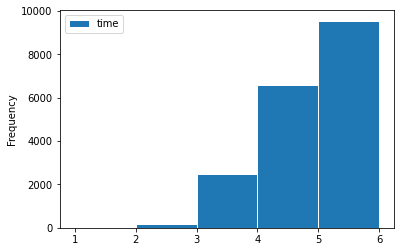

In [78]:
df.plot(kind='hist', by='time', ec='w', bins=np.arange(1,7))

In [79]:
df.get(['time']).mean()

time    4.59179
dtype: float64

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=56450c95-ff5c-4c86-bace-c4e8cc50083e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>